In [30]:
import matplotlib.pyplot as plt
from face_swap.image_preprocessing import *
from face_swap.utils import *
from face_swap.keypoints import *
import tqdm.notebook as tq

In [31]:
source_img_path = "data/f1.jpg"
target_img_path = "data/macron2.jpg"

source_img = read_image(source_img_path)
target_img = read_image(target_img_path)

s_aligned, s_ldmks = get_aligned_image(source_img)
t_aligned, t_ldmks = get_aligned_image(target_img)

Exception ignored in: <function tqdm.__del__ at 0x0000022B9B6252D0>
Traceback (most recent call last):
  File "c:\Users\Pc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "c:\Users\Pc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


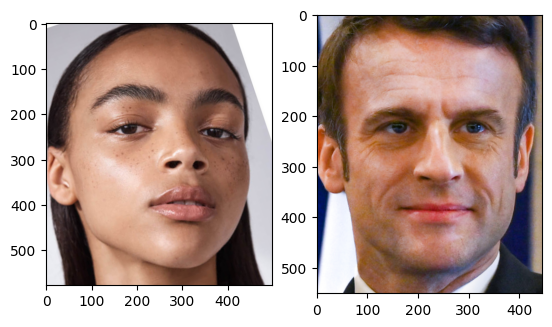

In [32]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(s_aligned)
axarr[1].imshow(t_aligned)

In [33]:

mixed_clone = t_aligned.copy()
added = np.zeros(t_aligned.shape, np.uint8)

for i in range(0, int(len(TRIANGULATION) / 3)):
    points = [TRIANGULATION[i * 3], TRIANGULATION[i * 3 + 1], TRIANGULATION[i * 3 + 2]]
    s_zone_ldmks = get_zone_landmarks(points, s_ldmks)
    t_zone_ldmks = get_zone_landmarks(points, t_ldmks)

    s_zone_patch = get_patch_image(s_aligned, points, s_ldmks)
    t_zone_patch = get_patch_image(t_aligned, points, t_ldmks)

    rotation_matrix, _ = cv2.estimateAffinePartial2D(s_zone_ldmks, t_zone_ldmks)
    s_rotated = cv2.warpAffine(
        s_zone_patch, 
        rotation_matrix, 
        (t_zone_patch.shape[1], t_zone_patch.shape[0])
        )
    
    added = cv2.add(added, s_rotated)

    t_scale_ldmks = get_zone_landmarks(points, t_ldmks)
    center_x = (np.max(t_scale_ldmks[:, 0]) + np.min(t_scale_ldmks[:, 0])) // 2
    center_y = (np.max(t_scale_ldmks[:, 1]) + np.min(t_scale_ldmks[:, 1])) // 2

    # 0 <= roi.x && 0 <= roi.width && roi.x + roi.width <= m.cols && 0 <= roi.y && 0 <= roi.height && roi.y + roi.height <= m.rows

    # mixed_clone = cv2.seamlessClone(
    #     s_rotated, 
    #     mixed_clone, 
    #     s_rotated[:, :, 0], 
    #     (center_x, center_y), 
    #     cv2.MIXED_CLONE
    #     )
    

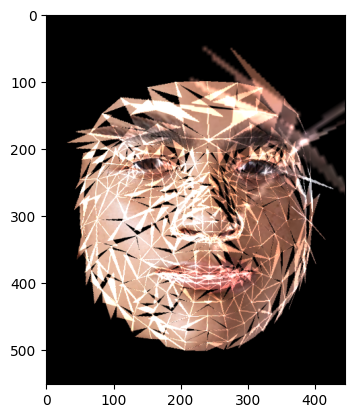

In [34]:
plt.imshow(added)